# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [12]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

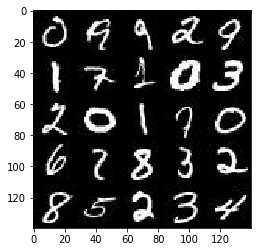

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

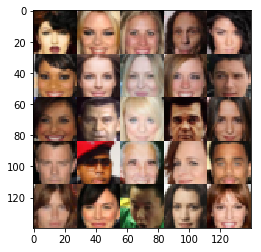

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests
import tensorflow as tf

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    image_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z_input = tf.placeholder(tf.float32, [None, z_dim])
    learning_rate = tf.placeholder(tf.float32)
    return image_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # 28x28x3
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        layer1 = tf.maximum(alpha * layer1, layer1)
        
        # 14x14x64
        
        layer2 = tf.layers.conv2d(layer1, 128, 5, strides=1, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.maximum(alpha * layer2, layer2)
        
        # 14x14x128
        
        layer2 = tf.layers.conv2d(layer1, 256, 5, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.maximum(alpha * layer2, layer2)
        
        # 7x7x256
        
        layer3 = tf.layers.conv2d(layer2, 512, 5, strides=1, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.maximum(alpha * layer3, layer3)
        
        # 7x7x512

        # Flatten
        flat = tf.reshape(layer3, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [28]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    with tf.variable_scope('generator', reuse=not is_train):
        
        
        net = tf.layers.dense(z, 7*7*512)
        
        # 7 * 7 * 512

        net = tf.reshape(net, (-1, 7, 7, 512))
        net = tf.layers.batch_normalization(net, training=is_train)
        net = tf.maximum(alpha * net, net)
        
        # 7x7x256
        
        net = tf.layers.conv2d_transpose(net, 256, 5, strides=1, padding='same')
        net = tf.layers.batch_normalization(net, training=is_train)
        net = tf.maximum(alpha * net, net)
        
        # 7x7x256
        
        net = tf.layers.conv2d_transpose(net, 128, 3, strides=1, padding='same')
        net = tf.layers.batch_normalization(net, training=is_train)
        net = tf.maximum(alpha * net, net)
        
        # 7x7x128
        
        net = tf.layers.conv2d_transpose(net, 64, 5, strides=2, padding='same')
        net = tf.layers.batch_normalization(net, training=is_train)
        net = tf.maximum(alpha * net, net)
        
        # 14x14x64
        
        # Output layer
        logits = tf.layers.conv2d_transpose(net, out_channel_dim, 5, strides=2, padding='same')
        
        # 28x28xout_channel_dim
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [29]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [30]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [31]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [33]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, save_path, resume=False):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every = 10
    show_every = 100
    
    image_channels = 3 if data_image_mode == 'RGB' else 1
    image_input_ph, z_input_ph, learning_rate_ph = model_inputs(28, 28, image_channels, z_dim)
    sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
    d_loss, g_loss = model_loss(image_input_ph, z_input_ph, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_ph, beta1)
    
    samples, losses = [], []
    steps = 0
    with tf.Session() as sess:
        saver = tf.train.Saver()
        if resume:
            saver.restore(sess, save_path)
        else:
            sess.run(tf.global_variables_initializer())
        total_iterations = len(list(get_batches(batch_size)))
        for epoch_i in range(epoch_count):
            for iteration, batch_images in enumerate(get_batches(batch_size)):
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={image_input_ph: batch_images, z_input_ph: batch_z, learning_rate_ph: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input_ph: batch_z, image_input_ph: batch_images, learning_rate_ph: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input_ph: batch_z, image_input_ph: batch_images})
                    train_loss_g = g_loss.eval({z_input_ph: batch_z})

                    print("Iteration {}/{}, Epoch {}/{} ".format(iteration + 1, total_iterations, epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f} ".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 50, z_input_ph, image_channels, data_image_mode)
            saver.save(sess, save_path)        
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Iteration 10/468, Epoch 1/1... Discriminator Loss: 0.7367... Generator Loss: 1.8949
Iteration 20/468, Epoch 1/1... Discriminator Loss: 0.2577... Generator Loss: 3.8771
Iteration 30/468, Epoch 1/1... Discriminator Loss: 0.1074... Generator Loss: 3.8980
Iteration 40/468, Epoch 1/1... Discriminator Loss: 0.2560... Generator Loss: 2.2503
Iteration 50/468, Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 9.0447
Iteration 60/468, Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 3.6786
Iteration 70/468, Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 2.6407
Iteration 80/468, Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 3.5129
Iteration 90/468, Epoch 1/1... Discriminator Loss: 0.1704... Generator Loss: 2.5389
Iteration 100/468, Epoch 1/1... Discriminator Loss: 0.0624... Generator Loss: 4.0849


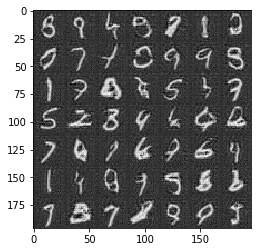

Iteration 110/468, Epoch 1/1... Discriminator Loss: 0.5058... Generator Loss: 1.4437
Iteration 120/468, Epoch 1/1... Discriminator Loss: 4.8316... Generator Loss: 0.0236
Iteration 130/468, Epoch 1/1... Discriminator Loss: 1.8050... Generator Loss: 0.3030
Iteration 140/468, Epoch 1/1... Discriminator Loss: 1.6459... Generator Loss: 0.3609
Iteration 150/468, Epoch 1/1... Discriminator Loss: 1.6026... Generator Loss: 0.3290
Iteration 160/468, Epoch 1/1... Discriminator Loss: 1.5741... Generator Loss: 0.3334
Iteration 170/468, Epoch 1/1... Discriminator Loss: 1.6748... Generator Loss: 0.3326
Iteration 180/468, Epoch 1/1... Discriminator Loss: 0.9301... Generator Loss: 0.8170
Iteration 190/468, Epoch 1/1... Discriminator Loss: 0.5645... Generator Loss: 2.8802
Iteration 200/468, Epoch 1/1... Discriminator Loss: 0.1834... Generator Loss: 2.6525


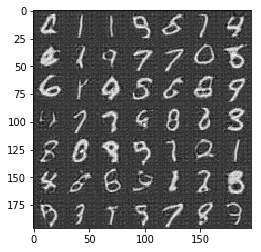

Iteration 210/468, Epoch 1/1... Discriminator Loss: 0.1487... Generator Loss: 3.1831
Iteration 220/468, Epoch 1/1... Discriminator Loss: 0.0528... Generator Loss: 4.4762
Iteration 230/468, Epoch 1/1... Discriminator Loss: 0.0465... Generator Loss: 4.2718
Iteration 240/468, Epoch 1/1... Discriminator Loss: 0.2185... Generator Loss: 4.9546
Iteration 250/468, Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 2.5847
Iteration 260/468, Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 2.8504
Iteration 270/468, Epoch 1/1... Discriminator Loss: 0.7880... Generator Loss: 2.8708
Iteration 280/468, Epoch 1/1... Discriminator Loss: 1.8295... Generator Loss: 4.3161
Iteration 290/468, Epoch 1/1... Discriminator Loss: 1.5750... Generator Loss: 0.4659
Iteration 300/468, Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.4911


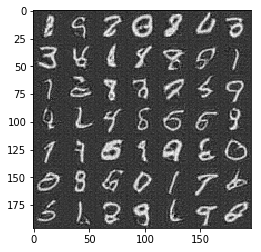

Iteration 310/468, Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 0.7433
Iteration 320/468, Epoch 1/1... Discriminator Loss: 2.6978... Generator Loss: 0.1454
Iteration 330/468, Epoch 1/1... Discriminator Loss: 1.5630... Generator Loss: 0.3650
Iteration 340/468, Epoch 1/1... Discriminator Loss: 1.5454... Generator Loss: 0.3718
Iteration 350/468, Epoch 1/1... Discriminator Loss: 0.4128... Generator Loss: 4.3428
Iteration 360/468, Epoch 1/1... Discriminator Loss: 0.2195... Generator Loss: 2.4492
Iteration 370/468, Epoch 1/1... Discriminator Loss: 0.5932... Generator Loss: 1.1915
Iteration 380/468, Epoch 1/1... Discriminator Loss: 0.8016... Generator Loss: 0.9491
Iteration 390/468, Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 0.7852
Iteration 400/468, Epoch 1/1... Discriminator Loss: 0.3323... Generator Loss: 1.8042


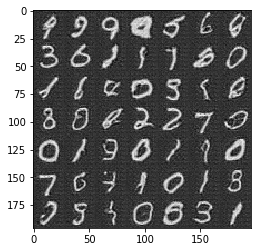

Iteration 410/468, Epoch 1/1... Discriminator Loss: 0.0699... Generator Loss: 4.4839
Iteration 420/468, Epoch 1/1... Discriminator Loss: 0.1811... Generator Loss: 2.2515
Iteration 430/468, Epoch 1/1... Discriminator Loss: 0.6668... Generator Loss: 2.7555
Iteration 440/468, Epoch 1/1... Discriminator Loss: 1.8880... Generator Loss: 0.2654
Iteration 450/468, Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 0.5870
Iteration 460/468, Epoch 1/1... Discriminator Loss: 1.9664... Generator Loss: 0.2565


In [36]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, 
          './checkpoints/generator.ckpt', True)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Iteration 10/1582, Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 0.9596
Iteration 20/1582, Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 0.7602
Iteration 30/1582, Epoch 1/1... Discriminator Loss: 2.2549... Generator Loss: 2.0890
Iteration 40/1582, Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 0.9681
Iteration 50/1582, Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 0.8217
Iteration 60/1582, Epoch 1/1... Discriminator Loss: 0.9442... Generator Loss: 1.1061
Iteration 70/1582, Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 1.2297
Iteration 80/1582, Epoch 1/1... Discriminator Loss: 1.6700... Generator Loss: 0.4337
Iteration 90/1582, Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 1.4404
Iteration 100/1582, Epoch 1/1... Discriminator Loss: 0.5691... Generator Loss: 1.5493


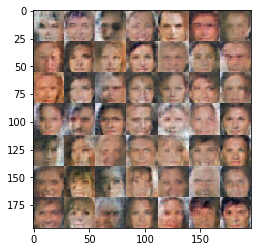

Iteration 110/1582, Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.5001
Iteration 120/1582, Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 0.7065
Iteration 130/1582, Epoch 1/1... Discriminator Loss: 0.8657... Generator Loss: 0.7347
Iteration 140/1582, Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 0.7860
Iteration 150/1582, Epoch 1/1... Discriminator Loss: 0.9602... Generator Loss: 0.7876
Iteration 160/1582, Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 0.8678
Iteration 170/1582, Epoch 1/1... Discriminator Loss: 0.8539... Generator Loss: 1.1368
Iteration 180/1582, Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.8956
Iteration 190/1582, Epoch 1/1... Discriminator Loss: 1.0530... Generator Loss: 0.7568
Iteration 200/1582, Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 0.7702


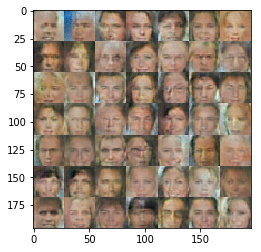

Iteration 210/1582, Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 0.9354
Iteration 220/1582, Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 0.9367
Iteration 230/1582, Epoch 1/1... Discriminator Loss: 0.9080... Generator Loss: 1.4411
Iteration 240/1582, Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 1.3865
Iteration 250/1582, Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 1.1266
Iteration 260/1582, Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 1.1162
Iteration 270/1582, Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.6605
Iteration 280/1582, Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 1.4157
Iteration 290/1582, Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.6584
Iteration 300/1582, Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 0.8021


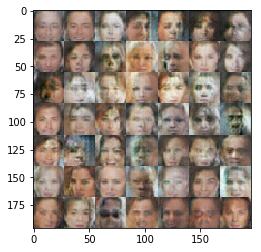

Iteration 310/1582, Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 1.2472
Iteration 320/1582, Epoch 1/1... Discriminator Loss: 1.0341... Generator Loss: 0.6215
Iteration 330/1582, Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 0.8434
Iteration 340/1582, Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 1.3153
Iteration 350/1582, Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.7160
Iteration 360/1582, Epoch 1/1... Discriminator Loss: 0.7036... Generator Loss: 0.8667
Iteration 370/1582, Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 0.7667
Iteration 380/1582, Epoch 1/1... Discriminator Loss: 1.7151... Generator Loss: 0.4567
Iteration 390/1582, Epoch 1/1... Discriminator Loss: 0.8783... Generator Loss: 0.8633
Iteration 400/1582, Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.8423


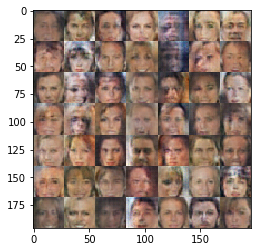

Iteration 410/1582, Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 1.0624
Iteration 420/1582, Epoch 1/1... Discriminator Loss: 0.8333... Generator Loss: 0.8756
Iteration 430/1582, Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 1.6073
Iteration 440/1582, Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.8370
Iteration 450/1582, Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 0.7988
Iteration 460/1582, Epoch 1/1... Discriminator Loss: 0.9786... Generator Loss: 0.9895
Iteration 470/1582, Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.9385
Iteration 480/1582, Epoch 1/1... Discriminator Loss: 0.7290... Generator Loss: 1.0710
Iteration 490/1582, Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.6786
Iteration 500/1582, Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 1.1374


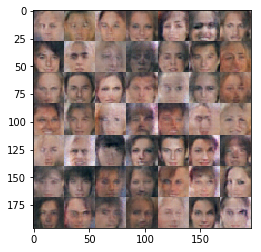

Iteration 510/1582, Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 1.1399
Iteration 520/1582, Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.5777
Iteration 530/1582, Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 1.1113
Iteration 540/1582, Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.7888
Iteration 550/1582, Epoch 1/1... Discriminator Loss: 1.0332... Generator Loss: 0.8955
Iteration 560/1582, Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 0.7024
Iteration 570/1582, Epoch 1/1... Discriminator Loss: 0.9438... Generator Loss: 0.8747
Iteration 580/1582, Epoch 1/1... Discriminator Loss: 0.9203... Generator Loss: 0.9410
Iteration 590/1582, Epoch 1/1... Discriminator Loss: 2.5651... Generator Loss: 0.3319
Iteration 600/1582, Epoch 1/1... Discriminator Loss: 1.5654... Generator Loss: 0.4378


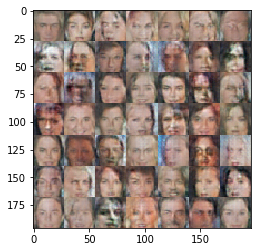

Iteration 610/1582, Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.9086
Iteration 620/1582, Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 1.2515
Iteration 630/1582, Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.4920
Iteration 640/1582, Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 0.5719
Iteration 650/1582, Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.6574
Iteration 660/1582, Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 0.8320
Iteration 670/1582, Epoch 1/1... Discriminator Loss: 0.9780... Generator Loss: 1.0713
Iteration 680/1582, Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 0.8105
Iteration 690/1582, Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 1.1576
Iteration 700/1582, Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.7780


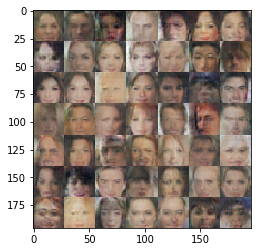

Iteration 710/1582, Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 0.9209
Iteration 720/1582, Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 1.1091
Iteration 730/1582, Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 1.1201
Iteration 740/1582, Epoch 1/1... Discriminator Loss: 0.7200... Generator Loss: 1.0454
Iteration 750/1582, Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 1.1612
Iteration 760/1582, Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.8621
Iteration 770/1582, Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 1.1620
Iteration 780/1582, Epoch 1/1... Discriminator Loss: 1.0259... Generator Loss: 0.8586
Iteration 790/1582, Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 0.7534
Iteration 800/1582, Epoch 1/1... Discriminator Loss: 2.1928... Generator Loss: 0.2284


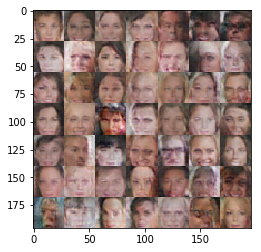

Iteration 810/1582, Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.9084
Iteration 820/1582, Epoch 1/1... Discriminator Loss: 0.7622... Generator Loss: 1.4745
Iteration 830/1582, Epoch 1/1... Discriminator Loss: 0.5914... Generator Loss: 1.4263
Iteration 840/1582, Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 0.9552
Iteration 850/1582, Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 0.7596
Iteration 860/1582, Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 0.7628
Iteration 870/1582, Epoch 1/1... Discriminator Loss: 0.9773... Generator Loss: 0.8492
Iteration 880/1582, Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 0.6657
Iteration 890/1582, Epoch 1/1... Discriminator Loss: 0.8244... Generator Loss: 0.8515
Iteration 900/1582, Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.4647


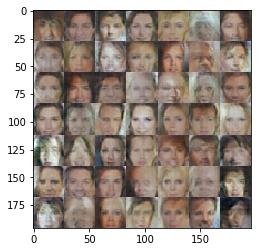

Iteration 910/1582, Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.8956
Iteration 920/1582, Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 0.7917
Iteration 930/1582, Epoch 1/1... Discriminator Loss: 0.8748... Generator Loss: 0.6674
Iteration 940/1582, Epoch 1/1... Discriminator Loss: 1.5874... Generator Loss: 0.5378
Iteration 950/1582, Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 1.2476
Iteration 960/1582, Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 1.0857
Iteration 970/1582, Epoch 1/1... Discriminator Loss: 0.5522... Generator Loss: 1.2652
Iteration 980/1582, Epoch 1/1... Discriminator Loss: 0.6138... Generator Loss: 1.1137
Iteration 990/1582, Epoch 1/1... Discriminator Loss: 1.8228... Generator Loss: 0.3069
Iteration 1000/1582, Epoch 1/1... Discriminator Loss: 1.5719... Generator Loss: 0.9524


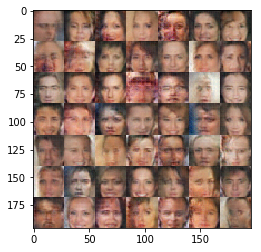

Iteration 1010/1582, Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.6582
Iteration 1020/1582, Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 0.7935
Iteration 1030/1582, Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.7455
Iteration 1040/1582, Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 1.8605
Iteration 1050/1582, Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 0.6783
Iteration 1060/1582, Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 0.7464
Iteration 1070/1582, Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 0.8474
Iteration 1080/1582, Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 1.0520
Iteration 1090/1582, Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 1.0747
Iteration 1100/1582, Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.6178


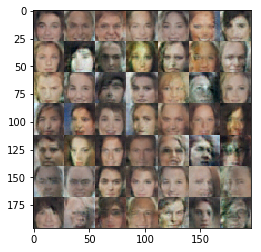

Iteration 1110/1582, Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.9351
Iteration 1120/1582, Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 1.3059
Iteration 1130/1582, Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.6611
Iteration 1140/1582, Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 0.6433
Iteration 1150/1582, Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.7174
Iteration 1160/1582, Epoch 1/1... Discriminator Loss: 0.8368... Generator Loss: 0.7109
Iteration 1170/1582, Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 1.6684
Iteration 1180/1582, Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 0.7963
Iteration 1190/1582, Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.7891
Iteration 1200/1582, Epoch 1/1... Discriminator Loss: 0.7891... Generator Loss: 0.7482


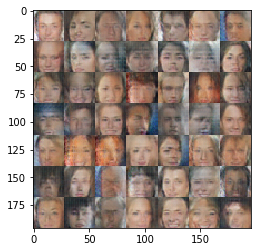

Iteration 1210/1582, Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.9189
Iteration 1220/1582, Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 1.7832
Iteration 1230/1582, Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 0.8499
Iteration 1240/1582, Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.8431
Iteration 1250/1582, Epoch 1/1... Discriminator Loss: 1.6172... Generator Loss: 0.3258
Iteration 1260/1582, Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 1.4869
Iteration 1270/1582, Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 0.8702
Iteration 1280/1582, Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 0.8291
Iteration 1290/1582, Epoch 1/1... Discriminator Loss: 1.0156... Generator Loss: 1.0445
Iteration 1300/1582, Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 1.0673


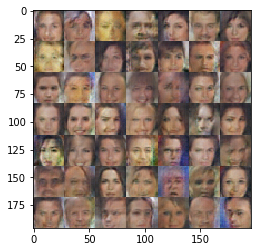

Iteration 1310/1582, Epoch 1/1... Discriminator Loss: 1.8530... Generator Loss: 1.9618
Iteration 1320/1582, Epoch 1/1... Discriminator Loss: 0.7102... Generator Loss: 0.8384
Iteration 1330/1582, Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.6149
Iteration 1340/1582, Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 0.5822
Iteration 1350/1582, Epoch 1/1... Discriminator Loss: 2.9129... Generator Loss: 2.5378
Iteration 1360/1582, Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.9464
Iteration 1370/1582, Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 0.8979
Iteration 1380/1582, Epoch 1/1... Discriminator Loss: 0.9630... Generator Loss: 0.8238
Iteration 1390/1582, Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 1.2886
Iteration 1400/1582, Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 0.6938


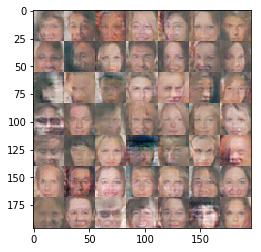

Iteration 1410/1582, Epoch 1/1... Discriminator Loss: 1.5192... Generator Loss: 1.3584
Iteration 1420/1582, Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.9330
Iteration 1430/1582, Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 0.9537
Iteration 1440/1582, Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.9528
Iteration 1450/1582, Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 0.7392
Iteration 1460/1582, Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.9605
Iteration 1470/1582, Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 1.0134
Iteration 1480/1582, Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.8995
Iteration 1490/1582, Epoch 1/1... Discriminator Loss: 0.7291... Generator Loss: 0.9941
Iteration 1500/1582, Epoch 1/1... Discriminator Loss: 0.9519... Generator Loss: 0.6068


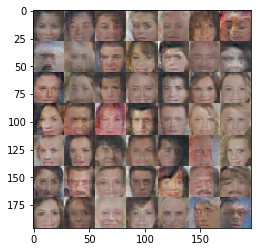

Iteration 1510/1582, Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 1.4375
Iteration 1520/1582, Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 1.0046
Iteration 1530/1582, Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 0.8534
Iteration 1540/1582, Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 1.3659
Iteration 1550/1582, Epoch 1/1... Discriminator Loss: 0.8031... Generator Loss: 0.9399
Iteration 1560/1582, Epoch 1/1... Discriminator Loss: 0.6070... Generator Loss: 1.0533
Iteration 1570/1582, Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 0.5754
Iteration 1580/1582, Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 1.8898


In [38]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode,
          './checkpoints/generator_celeba.ckpt', True)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.